In [1]:
import os
import json 

from matplotlib import pyplot as plt
import numpy as np


In [16]:
results_dir = "sc-CNN-training"
results_tree = list(os.walk(results_dir))

In [33]:
get_N_from_filename = lambda f: float(os.path.splitext(f)[0].split("_")[-1])

lr = []
N = []
history = []
for base, _, files in results_tree[1:]:
    setup_path = f"{base}/setup.json"
    with open(setup_path, "r") as f: setup = json.load(f)
    history_files = [f for f in files if f.startswith("model_")]
    for file in history_files:
        history_path = f"{base}/{file}"
        with open(history_path, "r") as f: history.append(json.load(f))
        N.append(get_N_from_filename(file))
        lr.append(setup['lr'])
lr = np.asarray(lr)
N = np.asarray(N)


(0.09, 0.105)

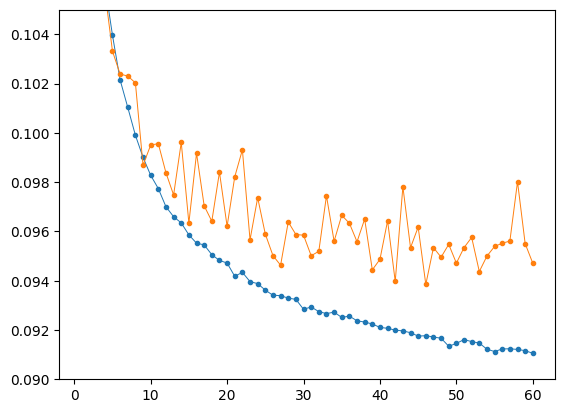

In [52]:
fig, ax = plt.subplots(1)
select = np.argwhere(np.isclose(lr, 0.005) & np.isclose(N, 10**7))[0][0] 
h = history[select]   
epochs = np.arange(1, len(h['loss']) + 1)
ax.plot(epochs, h["loss"], label="N=10^7",
        linewidth=0.7, marker='.')
ax.plot(epochs, h["val_loss"], label="N=10^7",
        linewidth=0.7, marker='.')
ax.set_ylim(0.09, 0.105)

(3.3, 4.0)

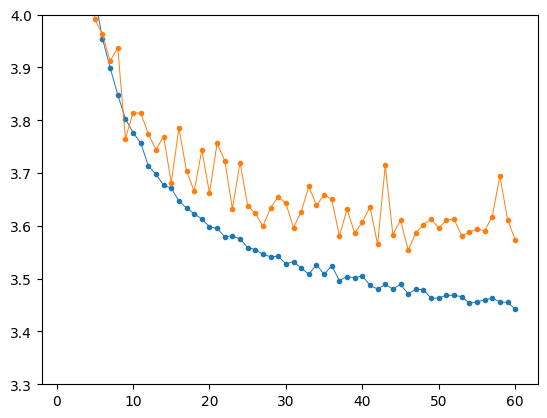

In [62]:
fig, ax = plt.subplots(1)
select = np.argwhere(np.isclose(lr, 0.005) & np.isclose(N, 10**7))[0][0] 
h = history[select]   
epochs = np.arange(1, len(h['loss']) + 1)
ax.plot(epochs, 100*(1 - np.asarray(h["accuracy"])), label="N=10^7",
        linewidth=0.7, marker='.')
ax.plot(epochs, 100*(1 - np.asarray(h["val_accuracy"])), label="N=10^7",
        linewidth=0.7, marker='.')
ax.set_ylim(3.3, 4)

(-0.4, 0.1)

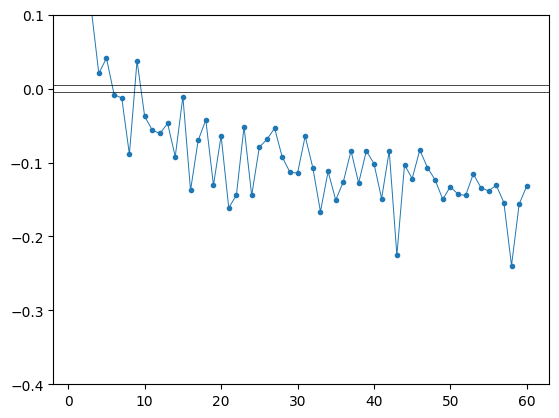

In [72]:
fig, ax = plt.subplots(1)
select = np.argwhere(np.isclose(lr, 0.005) & np.isclose(N, 10**7))[0][0] 
h = history[select]   
epochs = np.arange(1, len(h['loss']) + 1)
ax.plot(epochs, 100*(np.asarray(h["val_accuracy"]) - np.asarray(h["accuracy"])), label="N=10^7",
        linewidth=0.7, marker='.')
ax.axhline(0.005, color='black', linewidth=0.5)
ax.axhline(-0.005, color='black', linewidth=0.5)
ax.set_ylim(-0.4, 0.1)